In [12]:
import numpy as np
from pathlib import Path
import skimage as sk
import cv2 as cv
import skimage.io as skio
import skimage.color as skcolor
import skimage.transform as sktr
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import time

def load_image(path, greyscale=True):
    im = skio.imread(path)
    im = sk.img_as_float(im)
    
    # remove alpha if its there
    if im.shape[-1] == 4:
        im = skcolor.rgba2rgb(im)

    if greyscale and im.ndim == 3:
        im = skcolor.rgb2gray(im)
    return im

def save_image(path, im):
    skio.imsave(path, sk.img_as_ubyte(im))

def get_points(im1, im2=None):
    print('Please select 10 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2, p3, p4, p5, p6, p7, p8, p9, p10 = plt.ginput(10)
    plt.close()
    if im2 is None:
        return [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10]
    plt.imshow(im2)
    p11, p12, p13, p14, p15, p16, p17, p18, p19, p20 = plt.ginput(10)
    plt.close()
    return [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10], [p11, p12, p13, p14, p15, p16, p17, p18, p19, p20]

def get_4_points(im1):
    print('Please select 4 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2, p3, p4 = plt.ginput(4)
    plt.close()
    return [p1, p2, p3, p4]

# A.1: Shoot the Pictures

In [2]:
# Get Points
im1 = load_image('./images/set1/L1.jpg', greyscale=False)
im2 = load_image('./images/set1/L2.jpg', greyscale=False)

# downsize our images by 80%
h, w = im1.shape[:2]
im1 = sktr.resize(im1, (int(h * 0.20), int(w * 0.20)))
h, w = im2.shape[:2]
im2 = sktr.resize(im2, (int(h * 0.20), int(w * 0.20)))

%matplotlib qt
points1, points2 = get_points(im1, im2)
%matplotlib inline

Please select 10 points in each image for alignment.


# A.2: Recover Homographies

In [13]:
def computeH(im1_pts, im2_pts):
    A = []
    b = []
    for i in range(len(im1_pts)):
        x1, y1 = im1_pts[i]
        x2, y2 = im2_pts[i]
        A.append([x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2])
        A.append([0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2])

        b.append(x2)
        b.append(y2)
    
    A = np.array(A)
    b = np.array(b)
    h = np.linalg.lstsq(A, b, rcond=None)[0]
    H = np.append(h, 1).reshape(3, 3)
    return H

# A.3: Warp the Images

In [14]:
def get_warped_corners(im, H):
    h, w = im.shape[:2]
    corners = np.array([[0, 0, 1], [w-1, 0, 1], [w-1, h-1, 1], [0, h-1, 1]]).T
    
    warped_corners = H @ corners
    warped_corners /= warped_corners[2, :]

    x_min, y_min = np.min(warped_corners[:2, :], axis=1)
    x_max, y_max = np.max(warped_corners[:2, :], axis=1)

    return x_min, y_min, x_max, y_max

def warpImageNearestNeighbor(im, H):
    h, w = im.shape[:2]
    x_min, y_min, x_max, y_max = get_warped_corners(im, H)
    
    out_w = int(np.ceil(x_max - x_min))
    out_h = int(np.ceil(y_max - y_min))
    output_shape = (out_h, out_w)

    output = np.zeros(output_shape + im.shape[2:], dtype=im.dtype)
    H_inv = np.linalg.inv(H)
    for i in range(out_h):
        for j in range(out_w):
            target_point_h = np.array([j + x_min, i + y_min, 1])
            src_point = H_inv @ target_point_h
            src_x_normalized = src_point[0] / src_point[2]
            src_y_normalize = src_point[1] / src_point[2]

            src_y_neighbor = np.round(src_y_normalize).astype(int)
            src_x_neighbor = np.round(src_x_normalized).astype(int)

            if 0 <= src_x_neighbor < w and 0 <= src_y_neighbor < h:
                output[i, j] = im[src_y_neighbor, src_x_neighbor]
    return output

def warpImageBilinear(im, H):
    h, w = im.shape[:2]
    x_min, y_min, x_max, y_max = get_warped_corners(im, H)

    out_w = int(np.ceil(x_max - x_min))
    out_h = int(np.ceil(y_max - y_min))
    output_shape = (out_h, out_w)

    output = np.zeros(output_shape + im.shape[2:], dtype=im.dtype)
    H_inv = np.linalg.inv(H)

    for i in range(out_h):
        for j in range(out_w):
            target_point_h = np.array([j + x_min, i + y_min, 1])
            src_point_h = H_inv @ target_point_h
            
            src_x = src_point_h[0] / src_point_h[2] 
            src_y = src_point_h[1] / src_point_h[2] 

            x0 = int(np.floor(src_x))
            y0 = int(np.floor(src_y))
            x1 = x0 + 1
            y1 = y0 + 1
            
            if not (0 <= x0 and x1 < w and 0 <= y0 and y1 < h):
                continue

            dx = src_x - x0
            dy = src_y - y0
            
            interpolated_pixel = np.zeros(im.shape[2], dtype=im.dtype)
            for channel in range(im.shape[2]):
                top_left = im[y0, x0, channel]
                top_right = im[y0, x1, channel]
                bottom_left = im[y1, x0, channel]
                bottom_right = im[y1, x1, channel]
                top_interp = top_left * (1 - dx) + top_right * dx
                bottom_interp = bottom_left * (1 - dx) + bottom_right * dx
                interpolated_val = top_interp * (1 - dy) + bottom_interp * dy
                interpolated_pixel[channel] = interpolated_val
            
            output[i, j] = interpolated_pixel
            
    return output


In [15]:
to_rectify = load_image('./images/rectify/square3.jpg', greyscale=False)
h, w = to_rectify.shape[:2]

to_rectify = sktr.resize(to_rectify, (int(h * 0.2), int(w * 0.2)))

%matplotlib qt
rectify_points = get_4_points(to_rectify)
%matplotlib inline

points = np.array(rectify_points)
top_width = np.linalg.norm(points[0] - points[1])
bottom_width = np.linalg.norm(points[3] - points[2])
avg_width = int(np.mean([top_width, bottom_width]))

left_height = np.linalg.norm(points[0] - points[3])
right_height = np.linalg.norm(points[1] - points[2])
avg_height = int(np.mean([left_height, right_height]))

print(f"Output size: {avg_width}w x {avg_height}h")
points_dst = np.array([
    [0, 0],
    [avg_width - 1, 0],
    [avg_width - 1, avg_height - 1],
    [0, avg_height - 1]
])

H_rectify = computeH(rectify_points, points_dst)
bil_start = time.perf_counter()
rectified_bilinear = warpImageBilinear(to_rectify, H_rectify)
bil_end= time.perf_counter()

neighbor_start = time.perf_counter()
rectified_neighbor = warpImageNearestNeighbor(to_rectify, H_rectify)
neighbor_end= time.perf_counter()
n_time = neighbor_end - neighbor_start
b_time = bil_end - bil_start
print(f"Nearest Neighbor Time: {n_time:.4f}")
print(f"Bilinear Time: {b_time:.4f}")
save_image('./images/rectify/square3_rectified_neighbor.jpg', rectified_neighbor)
save_image('./images/rectify/square3_rectified_bilinear.jpg', rectified_bilinear)


Please select 4 points in each image for alignment.
Output size: 188w x 288h
Nearest Neighbor Time: 15.5631
Bilinear Time: 13.4649


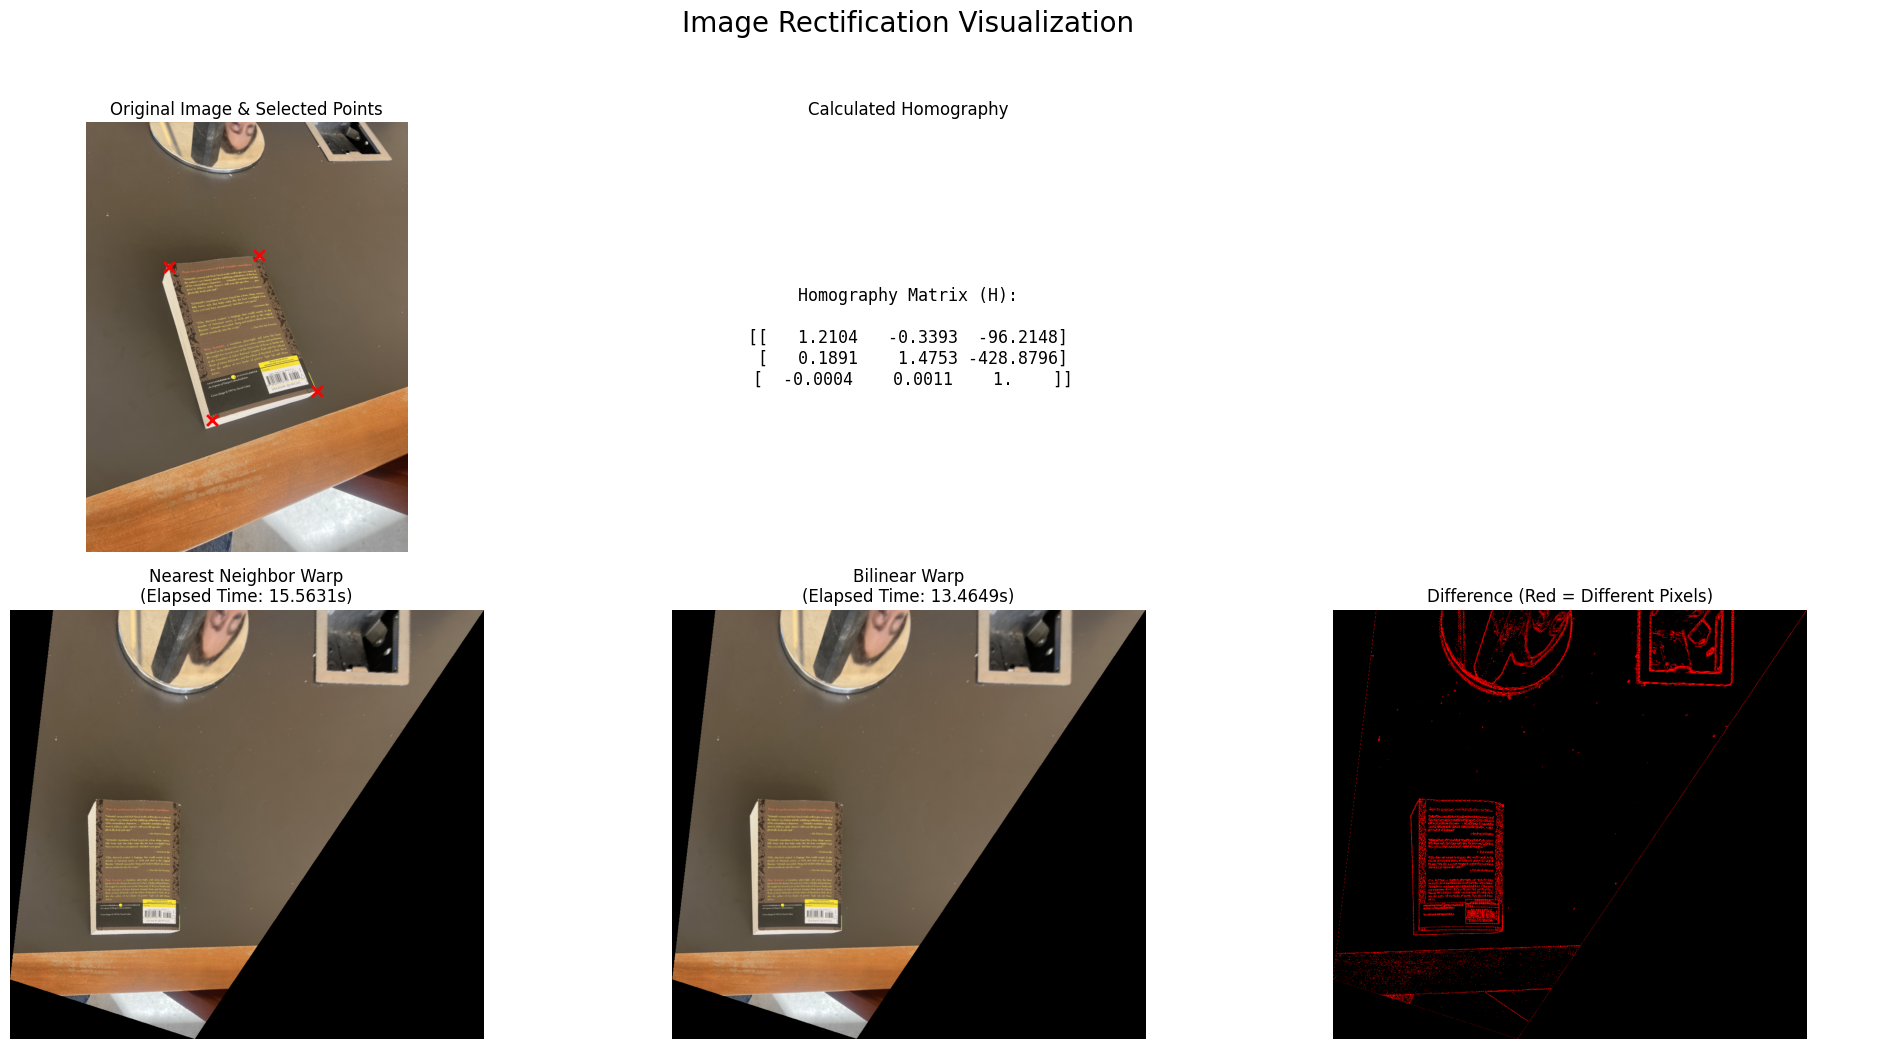

In [16]:
h_b, w_b = rectified_bilinear.shape[:2]
diff = np.abs(rectified_neighbor.astype(float) - rectified_bilinear.astype(float))
diff_mask = np.sum(diff, axis=2) > 0.05
diff_viz = np.zeros_like(rectified_bilinear)
diff_viz[diff_mask] = [1, 0, 0] # Red

fig, axs = plt.subplots(2, 3, figsize=(20, 11))
fig.suptitle('Image Rectification Visualization', fontsize=20)

axs[0, 0].imshow(to_rectify)
axs[0, 0].scatter(points[:, 0], points[:, 1], c='red', s=60, marker='x', linewidths=2)
axs[0, 0].set_title('Original Image & Selected Points')
axs[0, 0].axis('off')

axs[0, 1].axis('off')
h_text = "Homography Matrix (H):\n\n" + np.array2string(H_rectify, precision=4, suppress_small=True)
axs[0, 1].text(0.5, 0.5, h_text, ha='center', va='center', fontsize=12, fontfamily='monospace')
axs[0, 1].set_title('Calculated Homography')

axs[0, 2].axis('off')

axs[1, 0].imshow(rectified_neighbor)
axs[1, 0].set_title(f'Nearest Neighbor Warp\n(Elapsed Time: {n_time:.4f}s)')
axs[1, 0].axis('off')

axs[1, 1].imshow(rectified_bilinear)
axs[1, 1].set_title(f'Bilinear Warp\n(Elapsed Time: {b_time:.4f}s)')
axs[1, 1].axis('off')

axs[1, 2].imshow(diff_viz)
axs[1, 2].set_title('Difference (Red = Different Pixels)')
axs[1, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("./images/rectify/rectification_visualization.jpg")
plt.show()

# A.4

In [17]:
H = computeH(points1, points2)
print(H)

[[ 2.07439140e+00 -1.47127977e-02 -7.79810809e+02]
 [ 4.08192100e-01  1.76746357e+00 -1.91326568e+02]
 [ 1.37111617e-03 -2.71656979e-05  1.00000000e+00]]


In [18]:
def get_mosaic_canvas_size(images, homographies):
    all_corners = []
    for i, im in enumerate(images):
        h, w = im.shape[:2]
        corners = np.array([[0, w-1, w-1, 0], [0, 0, h-1, h-1], [1, 1, 1, 1]])
        warped_corners = homographies[i] @ corners
        warped_corners /= warped_corners[2, :]
        all_corners.append(warped_corners[:2, :])

    all_corners = np.hstack(all_corners)
    x_min, y_min = np.min(all_corners, axis=1)
    x_max, y_max = np.max(all_corners, axis=1)
    canvas_shape = (int(np.ceil(y_max - y_min)), int(np.ceil(x_max - x_min)))
    M_shift = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    return canvas_shape, M_shift

def create_mosaic(images, homographies, warp_func):
    canvas_shape, M_shift = get_mosaic_canvas_size(images, homographies)
    mosaic = np.zeros(canvas_shape + (images[0].shape[2],), dtype=images[0].dtype)

    for i, im in enumerate(images):
        H_final = M_shift @ homographies[i] # warp them onto a new projection
    
        h_im, w_im = im.shape[:2]
        corners = np.array([[0, w_im-1, w_im-1, 0], [0, 0, h_im-1, h_im-1], [1, 1, 1, 1]])
        warped_corners = H_final @ corners
        warped_corners /= warped_corners[2, :]
        x_min, y_min = np.min(warped_corners[:2, :], axis=1)
        
        warped_im = warp_func(im, H_final)
        
        h_small, w_small = warped_im.shape[:2]
        y_start = int(round(y_min))
        x_start = int(round(x_min))
        
        sub_mosaic = mosaic[y_start : y_start+h_small, x_start : x_start+w_small]
        mask = warped_im > 0
        sub_mosaic[mask] = warped_im[mask]
        mosaic[y_start : y_start+h_small, x_start : x_start+w_small] = sub_mosaic

    return mosaic

H_ref = np.eye(3)
    
images = [im1, im2]
homographies = [H, H_ref]

mosaic_image_neighbor = create_mosaic(images, homographies, warpImageNearestNeighbor)
mosaic_image_bilinear = create_mosaic(images, homographies, warpImageBilinear)
    
save_image("./images/set1/final_mosaic_neighbor.jpg", mosaic_image_neighbor)
save_image("./images/set1/final_mosaic_bilinear.jpg", mosaic_image_bilinear)